In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from pathlib import Path
from torch.utils.data import DataLoader

from torchfitter.trainer import Trainer
from torchfitter.utils import DataWrapper
from torchfitter.regularization import L1Regularization

from sklearn.model_selection import train_test_split

torch.manual_seed(0)
np.random.seed(0)

In [3]:
DATA_PATH = Path(os.path.abspath('')).parent / "tests/data"

In [4]:
X = np.load(DATA_PATH / "features.npy")
y = np.load(DATA_PATH / "labels.npy")

y = y.reshape(-1,1)

In [5]:
# simplest case of cross-validation
X_train, X_val, y_train, y_val = train_test_split(
    X, 
    y, 
    test_size=0.33, 
    random_state=42
)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
model = nn.Linear(in_features=1, out_features=1)
model.to(device)

regularizer = L1Regularization(regularization_rate=0.01, biases=False)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [8]:
from torchfitter.callbacks import LoggerCallback, EarlyStopping, LearningRateScheduler

In [9]:
callbacks = [
    LoggerCallback(update_step=100),
    EarlyStopping(patience=50, load_best=False),
    LearningRateScheduler(
        scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.9)
    )
]

In [10]:
trainer = Trainer(
    model=model, 
    criterion=criterion,
    optimizer=optimizer, 
    regularizer=regularizer,
    device=device,
    callbacks=callbacks
)

In [11]:
# wrap data in Dataset
train_wrapper = DataWrapper(
    X_train, 
    y_train, 
    dtype_X='float', 
    dtype_y='float'
)
val_wrapper = DataWrapper(
    X_val,
    y_val,
    dtype_X='float',
    dtype_y='float'
)

# torch Loaders
train_loader = DataLoader(train_wrapper, batch_size=64, pin_memory=True)
val_loader = DataLoader(val_wrapper, batch_size=64, pin_memory=True)

----

In [12]:
from torchfitter.callbacks import ExperimentSaver
from torchfitter.callbacks.base import ManagerCallback

In [13]:
from torchfitter.manager import Manager

In [14]:
class Restarter(ManagerCallback):
    def __init__(self):
        pass
    
    def on_seed_experiment_end(self, params_dict):
        pass

In [15]:
callbacks_manager = [
    ExperimentSaver(checkpoint_path='checkpoint.pt', folder_name='experiment')
]

In [16]:
# define random seeds
seeds = (0, 5, 10)

manager = Manager(
    trainer=trainer,
    seeds=seeds,
    callbacks=callbacks_manager
)

In [17]:
manager.run_experiments(train_loader, val_loader, 5000)

  0%|          | 0/5000 | ? epoch/s, ramaining_time: ? s

INFO:root:Starting training process on cuda
INFO:root:End of training. Total time: 210.20101 seconds
INFO:root:Early stopping applied at epoch: 3897
INFO:root:Ending training on seed 0


  0%|          | 0/5000 | ? epoch/s, ramaining_time: ? s

INFO:root:Starting training process on cuda
INFO:root:End of training. Total time: 213.03680 seconds
INFO:root:Early stopping applied at epoch: 3902
INFO:root:Ending training on seed 5


  0%|          | 0/5000 | ? epoch/s, ramaining_time: ? s

INFO:root:Starting training process on cuda
INFO:root:End of training. Total time: 213.52760 seconds
INFO:root:Early stopping applied at epoch: 3879
INFO:root:Ending training on seed 10


In [18]:
from torchfitter.io import load_pickle

In [19]:
experiments = {}

for seed in seeds:
    mod = torch.load(f'experiment_{seed}/model_parameters.pt')
    best = torch.load(f'experiment_{seed}/best_parameters.pt')
    op = torch.load(f'experiment_{seed}/optim_parameters.pt')
    hist = load_pickle(f'experiment_{seed}/history.pkl')
    
    experiments[seed] = {}
    
    experiments[seed]['model'] = mod
    experiments[seed]['best_model'] = best
    experiments[seed]['optimizer'] = op
    experiments[seed]['history'] = hist

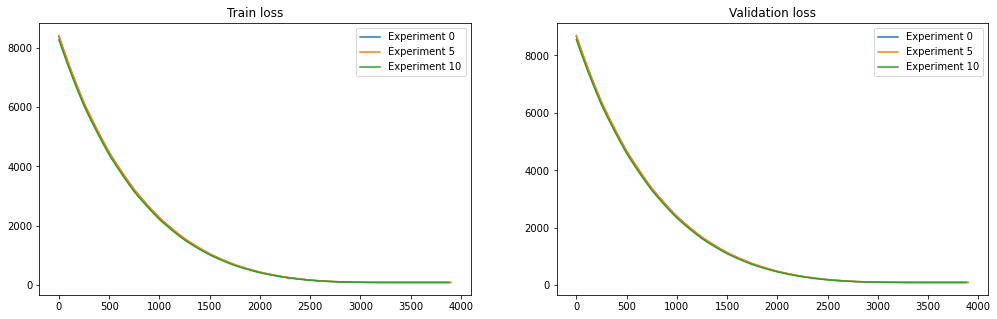

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))

for key in experiments.keys():
    hist = experiments[key]['history']
    
    ax[0].plot(hist['train_loss'], label=f'Experiment {key}')
    ax[0].set_title('Train loss')
    ax[0].legend()
    
    ax[1].plot(hist['validation_loss'], label=f'Experiment {key}')
    ax[1].set_title('Validation loss')
    ax[1].legend()

----

In [21]:
experiments[0]['model']

OrderedDict([('weight', tensor([[90.8696]], device='cuda:0')),
             ('bias', tensor([0.0945], device='cuda:0'))])

In [22]:
experiments[0]['best_model']

OrderedDict([('weight', tensor([[90.8696]], device='cuda:0')),
             ('bias', tensor([0.0942], device='cuda:0'))])

---

In [23]:
experiments[5]['model']

OrderedDict([('weight', tensor([[90.8696]], device='cuda:0')),
             ('bias', tensor([0.0944], device='cuda:0'))])

In [24]:
experiments[5]['best_model']

OrderedDict([('weight', tensor([[90.8696]], device='cuda:0')),
             ('bias', tensor([0.0942], device='cuda:0'))])

----

In [25]:
experiments[10]['model']

OrderedDict([('weight', tensor([[90.8696]], device='cuda:0')),
             ('bias', tensor([0.0946], device='cuda:0'))])

In [26]:
experiments[10]['best_model']

OrderedDict([('weight', tensor([[90.8696]], device='cuda:0')),
             ('bias', tensor([0.0944], device='cuda:0'))])